In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
PARENT_DIR = "/content/gdrive/My Drive/EBAY"
DATA_DIR = PARENT_DIR + "/data"
DATA_PATH = DATA_DIR + "/data.csv"
VER = "BertForTokenClassification"

OUTPUT_DIR = PARENT_DIR + "/output/"+VER
MODEL_DIR = PARENT_DIR + "/model/"+VER

MODEL_PATH = MODEL_DIR + "/pytorch_model.bin"
CONFIG_PATH = MODEL_DIR + "/config.json"
VOCAB_PATH = MODEL_DIR + "/vocab.txt"
BERT = "bert-base-cased"
REPORT_PATH = OUTPUT_DIR + "/results.txt"

In [4]:
import os
if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

In [5]:
batch_size = 8
max_len = 128
epochs = 10
max_grad_norm = 1.0
full_finetuning = False
lr = 0.001

In [6]:
!pip install seqeval
!pip install transformers

In [7]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from sklearn.metrics import classification_report,accuracy_score,f1_score, multilabel_confusion_matrix
import torch.nn.functional as F

import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, TensorDataset
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel # BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.autograd import Variable
import seaborn as sns

In [8]:
df = pd.read_csv(DATA_PATH)

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values for decades
df['label'] = labelencoder.fit_transform(df['Decade'])
num_of_labels = len(df['label'].unique())
classes = list(labelencoder.classes_)
df.head()

,Decade,Age,Title,Review Text,Division Name,Department Name,Class Name,label
0,1980,33,NaN,Absolutely wonderful - silky and sexy and comf...,Initmates,Intimate,Intimates,6
1,1980,34,NaN,Love this dress! it's sooo pretty. i happene...,General,Dresses,Dresses,6
2,1960,60,Some major design flaws,I had such high hopes for this dress and reall...,General,Dresses,Dresses,4
3,1970,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Bottoms,Pants,5
4,1970,47,Flattering shirt,This shirt is very flattering to all due to th...,General,Tops,Blouses,5


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

In [10]:
# Splitting into train val and test splits
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Review Text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
print(train_text)
print(train_labels)

21285    Great romper i personally would not wear it fo...
19034    I tried on xs petites as someone had returned ...
22154    I really wanted to like this jump suit.  i rar...
5378     This jacket looks like such the statement piec...
6909     I loved this dress and was hoping to keep it. ...
                               ...                        
21304    Beautiful dress. the dress appears more blue i...
16418    I loved this sweater! it is a little thin, so ...
7368     This is one of the softest blouses i now own. ...
6050     I bought this as a "reward." i have wanted a l...
10761    I absolutely love this jacket! it's one of the...
Name: Review Text, Length: 15848, dtype: object
21285    7
19034    6
22154    3
5378     5
6909     5
        ..
21304    4
16418    5
7368     7
6050     4
10761    5
Name: label, Length: 15848, dtype: int64


In [12]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT,do_lower_case=False)

In [13]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_len,
    pad_to_max_length=True,
    truncation=True
)

## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
print(f"Train size: {train_seq.shape}, Val size: {val_seq.shape}, Test size: {test_seq.shape}")

Train size: torch.Size([15848, 128]), Val size: torch.Size([3396, 128]), Test size: torch.Size([3397, 128])


In [42]:
# model = BertForSequenceClassification.from_pretrained(BERT, num_labels=num_of_labels)

embedding = BertModel.from_pretrained(BERT)
# Based on KimCNN for sequence classification
class CNNForTextClassification(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(CNNForTextClassification, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        # self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        if self.static:
            x = Variable(x)
            
        x = x.unsqueeze(1)  # (N, Ci, V, D)

        x = [F.relu(conv(x)) for conv in self.convs1]  # [(N, Co, V), ...]*len(Ks)
        print([i.shape for i in x])
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        # output = self.sigmoid(logit)
        return logit

model = CNNForTextClassification(
    embed_num=max_len,
    embed_dim=batch_size,
    class_num=len(classes),
    kernel_num=3,
    kernel_sizes=[2,3,4],
    dropout=0.5,
    static=True,
)

In [43]:
embedding.cuda();
model.cuda();

In [17]:
# if full_finetuning:
#     # Fine tune model all layer parameters
#     param_optimizer = list(model.named_parameters())
#     no_decay = ['bias', 'gamma', 'beta']
#     optimizer_grouped_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.01},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#          'weight_decay_rate': 0.0}
#     ]
# else:
#     # Only fine tune classifier parameters
#     param_optimizer = list(model.classifier.named_parameters()) 
#     optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(model.parameters(), lr=lr)

# Total number of training steps is number of batches * number of epochs.
# total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [18]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

Class Weights: [195.65432099  29.34814815   9.07674685   1.25241031   0.66473722
   0.44099396   0.3333123    0.81901809  16.93162393]


In [19]:
# function to train the model
def train():
  print("\nTraining...")
  
  model.train(True)

  total_loss = 0

  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    b_input_ids, b_input_mask, b_labels = batch

    word_embd = embedding(b_input_ids, attention_mask=b_input_mask)

    # get model predictions for the current batch
    outputs = model(word_embd[0])

    # clear previously calculated gradients 
    optimizer.zero_grad()        

    # compute the loss between actual and predicted values
    loss = cross_entropy(outputs.view(-1, num_of_labels), b_labels.view(-1))

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)

    # update parameters
    optimizer.step()

    # add on to the total loss
    total_loss = total_loss + loss.item()

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  return avg_loss

In [20]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss = 0
  
  # empty list to save the model predictions
  y_pred, y_true = [], []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    b_input_ids, b_input_mask, b_labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      word_embd = embedding(b_input_ids, attention_mask=b_input_mask)

      # get model predictions for the current batch
      outputs = model(word_embd[0])

      # clear previously calculated gradients 
      optimizer.zero_grad()        

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(outputs.view(-1, num_of_labels), b_labels.view(-1))

      total_loss = total_loss + loss.item()

      y_pred.extend(torch.argmax(outputs, 1).tolist())
      y_true.extend(b_labels.tolist())

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  print('Classification Report:')
  print(classification_report(y_true, y_pred, target_names=[str(c) for c in classes], digits=4))

  return avg_loss, y_true, y_pred

In [44]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for _ in trange(epochs,desc="Epoch"):
    
    #train model
    train_loss = train()

    # append training loss
    train_losses.append(train_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')

    #evaluate model
    valid_loss, _, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        savemodel = model.module if hasattr(model, 'module') else model
        torch.save(savemodel.state_dict(), MODEL_PATH)
        savemodel.config.to_json_file(CONFIG_PATH)
        tokenizer.save_vocabulary(MODEL_DIR)
    
    valid_losses.append(valid_loss)

    print(f'Validation Loss: {valid_loss:.3f}')

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


Training...


RuntimeError: ignored

In [ ]:
!ls '$MODEL_DIR'

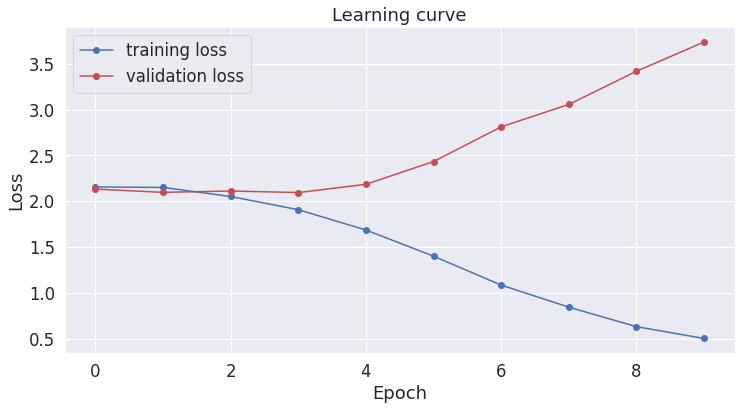

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(train_losses, 'b-o', label="training loss")
plt.plot(valid_losses, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.savefig(OUTPUT_DIR + "/loss.png")

plt.show()

# Test

In [ ]:
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

print("\nTesting...")
  
# deactivate dropout layers
model.eval()

# empty list to save the model predictions
y_pred, y_true = [], []

# iterate over batches
for step,batch in enumerate(test_dataloader):

  # push the batch to gpu
  batch = [t.to(device) for t in batch]

  b_input_ids, b_input_mask, b_labels = batch

  # deactivate autograd
  with torch.no_grad():
    
    # model predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels = None)

    y_pred.extend(torch.argmax(outputs[0], 1).tolist())
    y_true.extend(b_labels.tolist())

# Get acc , recall, F1 result report
report = classification_report(y_true, y_pred, zero_division=1, digits=4)


# Save the report into file
with open(REPORT_PATH, "w") as writer:
    print("***** Eval results(Lenient) *****")
    print("\n%s"%(report))
    print("F1 score: %f"%(f1_score(y_true, y_pred,zero_division=1)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("F1 score(Lenient):\n")
    writer.write(str(f1_score(y_true, y_pred)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report)


print(multilabel_confusion_matrix(y_true, y_pred, labels=[str(c) for c in classes]))